Q1

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def difference(f1, f2):
  g1 = cv2.cvtColor(f1, cv2.COLOR_BGR2GRAY)
  g2 = cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY)

  diff = cv2.absdiff(g1, g2)

  return diff

input_video = cv2.VideoCapture("/content/Sample2.mp4")

frame_width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 40

output_video = "output_video_2.avi"
a = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

correct_read, previous_frame = input_video.read()

count = 0

while True:
  correct_read, current_frame = input_video.read()
  if not correct_read:
    break

  new_frame = difference(previous_frame, current_frame)

  a.write(cv2.cvtColor(new_frame, cv2.COLOR_GRAY2BGR))

  previous_frame = current_frame

  count+=1
print(count)


299


Q2 Canny

In [14]:
import cv2
import numpy as np

def difference(f1, f2):
    g1 = cv2.cvtColor(f1, cv2.COLOR_BGR2GRAY)
    g2 = cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY)

    diff = cv2.absdiff(g1, g2)

    return diff

input_video = cv2.VideoCapture("/content/Sample2.mp4")

frame_width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 40

output_video = "output_video_canny_2.avi"
a = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

correct_read, previous_frame = input_video.read()

while True:
    correct_read, current_frame = input_video.read()
    if not correct_read:
        break

    new_frame = difference(previous_frame, current_frame)

    edges = cv2.Canny(new_frame, 100, 200)

    edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    a.write(edges_bgr)

    previous_frame = current_frame

a.release()


Q2 Canny without NMS

In [41]:
import cv2
from google.colab.patches import cv2_imshow

def custom_edge_detection(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray_frame, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_frame, cv2.CV_64F, 0, 1, ksize=3)

    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)

    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)

    return edges.astype('uint8')

video_path = '/content/Sample2.mp4'
cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 40

out = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('output_video_canny_nonms_2.mp4', out, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    edges_frame = custom_edge_detection(frame)

    output_video.write(edges_frame)

cap.release()
output_video.release()
cv2.destroyAllWindows()

Q2 DOG

In [24]:
import cv2
import numpy as np

def generate_gaussian_kernel(sigma, size):
    kernel = cv2.getGaussianKernel(size, sigma)
    return np.outer(kernel, kernel)

def difference_of_gaussians(f1, f2, sigma1, sigma2):
    g1 = cv2.filter2D(f1, -1, generate_gaussian_kernel(sigma1, 5))
    g2 = cv2.filter2D(f2, -1, generate_gaussian_kernel(sigma2, 5))

    diff = np.abs(g1 - g2)

    return diff

input_video = cv2.VideoCapture("/content/sample1.mp4")

frame_width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 40

output_video = "output_video_DOG_1.avi"
a = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height), isColor=False)

correct_read, previous_frame = input_video.read()

count = 0

while True:
    correct_read, current_frame = input_video.read()
    if not correct_read:
        break

    blurred_previous = cv2.GaussianBlur(previous_frame, (5, 5), 0)
    blurred_current = cv2.GaussianBlur(current_frame, (5, 5), 0)

    new_frame = difference_of_gaussians(blurred_previous, blurred_current, 2.5, 3)

    gray_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)

    a.write(gray_frame)

    previous_frame = current_frame

    count += 1

print(count)

a.release()
input_video.release()


196


Q3 Using good features to track

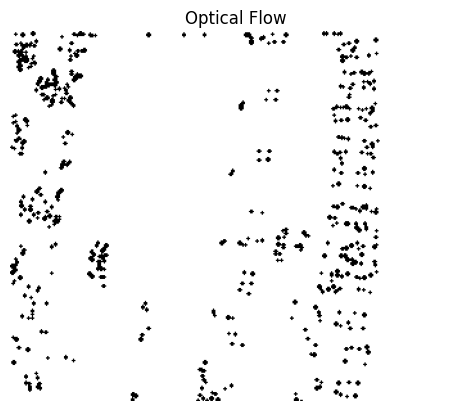

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def inRange(cordinates, limits):
    x, y = cordinates
    X_Limit, Y_Limit = limits
    return 0 <= x and x < X_Limit and 0 <= y and y < Y_Limit

def optical_flow(old_frame, new_frame, window_size, min_quality=0.01):
    max_corners = 10000
    min_distance = 0.1
    feature_list = cv2.goodFeaturesToTrack(old_frame, max_corners, min_quality, min_distance)

    w = int(window_size/2)

    old_frame = old_frame / 255
    new_frame = new_frame / 255

    kernel_x = np.array([[-1, 1], [-1, 1]])
    kernel_y = np.array([[-1, -1], [1, 1]])
    kernel_t = np.array([[1, 1], [1, 1]])

    fx = cv2.filter2D(old_frame, -1, kernel_x)
    fy = cv2.filter2D(old_frame, -1, kernel_y)
    ft = cv2.filter2D(new_frame, -1, kernel_t) - cv2.filter2D(old_frame, -1, kernel_t)

    u = np.zeros(old_frame.shape)
    v = np.zeros(old_frame.shape)

    for feature in feature_list:
        j, i = feature.ravel()
        i, j = int(i), int(j)

        I_x = fx[i-w:i+w+1, j-w:j+w+1].flatten()
        I_y = fy[i-w:i+w+1, j-w:j+w+1].flatten()
        I_t = ft[i-w:i+w+1, j-w:j+w+1].flatten()

        b = np.reshape(I_t, (I_t.shape[0], 1))
        A = np.vstack((I_x, I_y)).T

        U = np.matmul(np.linalg.pinv(A), b)

        u[i, j] = U[0][0]
        v[i, j] = U[1][0]

    return (u, v)

def lucaskanade(old_frame, new_frame, U, V):
    displacement = np.ones_like(new_frame)
    displacement.fill(255.)
    line_color = (0, 0, 0)

    for i in range(new_frame.shape[0]):
        for j in range(new_frame.shape[1]):
            start_pixel = (i, j)
            end_pixel = (int(i+U[i][j]), int(j+V[i][j]))

            if U[i][j] and V[i][j] and inRange(end_pixel, old_frame.shape):
                displacement = cv2.arrowedLine(displacement, start_pixel, end_pixel, line_color, thickness=2)

    return displacement

img1 = cv2.imread("LKframe1.png")
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("LKframe2.png")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

U, V = optical_flow(img1_gray, img2_gray, 3, 0.05)

flow_image = lucaskanade(img1_gray, img2_gray, U, V)

cv2.imwrite("optical_flow.png", flow_image)

plt.imshow(flow_image, cmap="gray")
plt.title("Optical Flow")
plt.axis('off')
plt.show()


In [45]:

video_path = 'Sample3.mpg'
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_path = 'output_video_optical_flow.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

ret, old_frame = cap.read()
old_frame_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

while True:

    ret, new_frame = cap.read()
    if not ret:
        break
    new_frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)

    U, V = optical_flow(old_frame_gray, new_frame_gray, window_size=3, min_quality=0.01)


    for i in range(new_frame.shape[0]):
        for j in range(new_frame.shape[1]):
            u, v = U[i][j], V[i][j]
            if u != 0 and v != 0:
                end_point = (int(round(j + u)), int(round(i + v)))
                new_frame = cv2.arrowedLine(new_frame, (j, i), end_point, (0, 255, 0), thickness=1)

    out.write(new_frame)
    old_frame_gray = new_frame_gray



Q3 using Harris Corner Detection

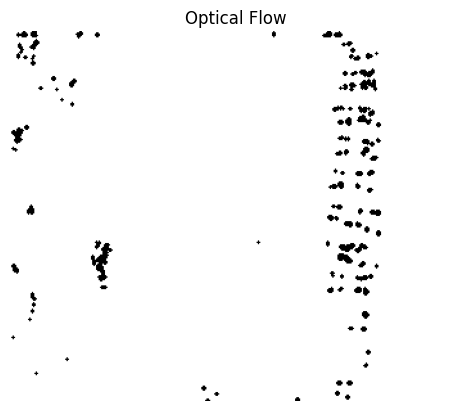

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def inRange(cordinates, limits):
    x, y = cordinates
    X_Limit, Y_Limit = limits
    return 0 <= x and x < X_Limit and 0 <= y and y < Y_Limit

def optical_flow(old_frame, new_frame, window_size, min_quality=0.01):
    min_distance = 0.1
    k = 0.04

    corners = cv2.cornerHarris(np.float32(old_frame), 2, 3, k)

    feature_mask = (corners > min_quality * corners.max()).astype(int)

    feature_list = np.argwhere(feature_mask == 1)

    w = int(window_size/2)

    old_frame = old_frame / 255
    new_frame = new_frame / 255

    kernel_x = np.array([[-1, 1], [-1, 1]])
    kernel_y = np.array([[-1, -1], [1, 1]])
    kernel_t = np.array([[1, 1], [1, 1]])

    fx = cv2.filter2D(old_frame, -1, kernel_x)
    fy = cv2.filter2D(old_frame, -1, kernel_y)
    ft = cv2.filter2D(new_frame, -1, kernel_t) - cv2.filter2D(old_frame, -1, kernel_t)

    u = np.zeros(old_frame.shape)
    v = np.zeros(old_frame.shape)

    for feature in feature_list:
        i, j = feature

        I_x = fx[i-w:i+w+1, j-w:j+w+1].flatten()
        I_y = fy[i-w:i+w+1, j-w:j+w+1].flatten()
        I_t = ft[i-w:i+w+1, j-w:j+w+1].flatten()

        b = np.reshape(I_t, (I_t.shape[0], 1))
        A = np.vstack((I_x, I_y)).T

        U = np.matmul(np.linalg.pinv(A), b)

        u[i, j] = U[0][0]
        v[i, j] = U[1][0]

    return (u, v)

def lucaskanade(old_frame, new_frame, U, V):
    displacement = np.ones_like(new_frame)
    displacement.fill(255.)
    line_color = (0, 0, 0)

    for i in range(new_frame.shape[0]):
        for j in range(new_frame.shape[1]):
            start_pixel = (i, j)
            end_pixel = (int(i+U[i][j]), int(j+V[i][j]))

            if U[i][j] and V[i][j] and inRange(end_pixel, old_frame.shape):
                displacement = cv2.arrowedLine(displacement, start_pixel, end_pixel, line_color, thickness=2)

    return displacement

img1 = cv2.imread("LKframe1.png")
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("LKframe2.png")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

U, V = optical_flow(img1_gray, img2_gray, 3, 0.05)

flow_image = lucaskanade(img1_gray, img2_gray, U, V)

cv2.imwrite("optical_flow.png", flow_image)

plt.imshow(flow_image, cmap="gray")
plt.title("Optical Flow")
plt.axis('off')
plt.show()


In [47]:

video_path = 'Sample3.mpg'
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_path = 'output_video_optical_flow_harris.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

ret, old_frame = cap.read()
old_frame_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

while True:

    ret, new_frame = cap.read()
    if not ret:
        break
    new_frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)

    U, V = optical_flow(old_frame_gray, new_frame_gray, window_size=3, min_quality=0.01)


    for i in range(new_frame.shape[0]):
        for j in range(new_frame.shape[1]):
            u, v = U[i][j], V[i][j]
            if u != 0 and v != 0:
                end_point = (int(round(j + u)), int(round(i + v)))
                new_frame = cv2.arrowedLine(new_frame, (j, i), end_point, (0, 255, 0), thickness=1)

    out.write(new_frame)
    old_frame_gray = new_frame_gray

